<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Мы построим модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

Загрузим данные и первично ознакомимся с ними.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Так как мы будем работать с временным рядом, изменим тип данных с object на datetime64

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим индекс таблицы равным столбцу datetime

In [6]:
df = df.set_index('datetime')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, расположены ли данные в хронологическом порядке

In [8]:
df = df.sort_index()
print(df.index.is_monotonic)
print(df.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Посмотрим, за какой период у нас есть данные

In [9]:
print(df.iloc[[0, -1]])

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-08-31 23:50:00          53


<AxesSubplot:xlabel='datetime'>

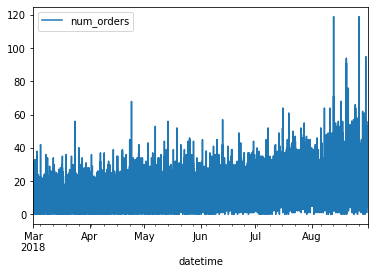

In [10]:
df.plot()

Ресемплируем данные по одному часу.

<AxesSubplot:xlabel='datetime'>

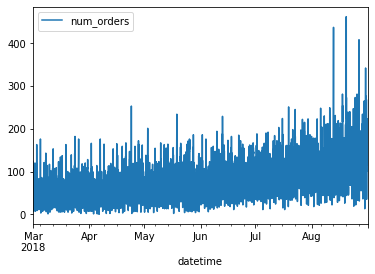

In [11]:
df = df.resample('1H').sum()
df.plot()

## Анализ

Рассмотрим тренд, сезонность и остатки. 

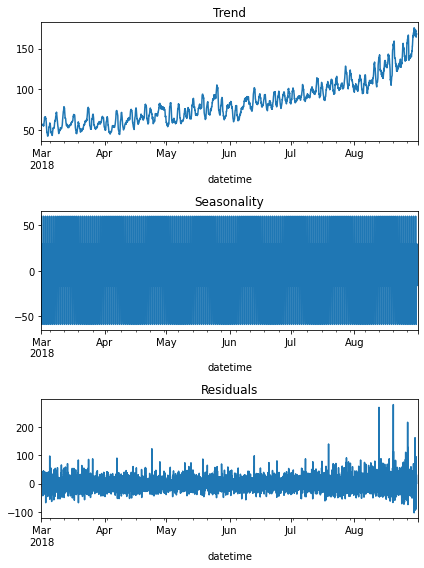

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Видим тренд на увеличение. Посмотрим на сезонность в контексте одного дня и одного часа. Например, возьмём по неделе из двух месяцев.

<AxesSubplot:xlabel='datetime'>

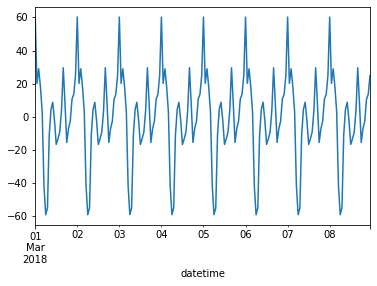

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

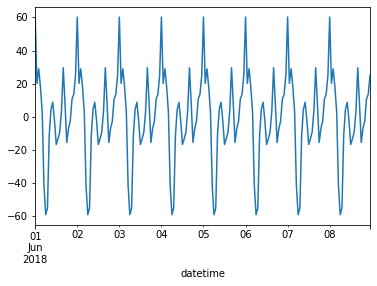

In [14]:
decomposed.seasonal['2018-06-01':'2018-06-08'].plot(ax=plt.gca())

Видим, что в течение недели показатель практически не меняется. Дело, очевидно, во времени дня. Поэтому теперь посмотрим, как меняется число заказов в течение дня. 

<AxesSubplot:xlabel='datetime'>

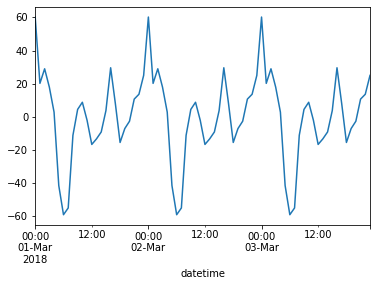

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())

В пкрвые три дня марта, как мы видим, проследивается четкая сезонность: пик находится около полуночи часов, так же есть пик около 16 часов и 10 часов. Самый большой спад - в районе 6 утра, также спады около 12 часов и 18 часов. Посмотрим на те же данные, например,  в июне. 

<AxesSubplot:xlabel='datetime'>

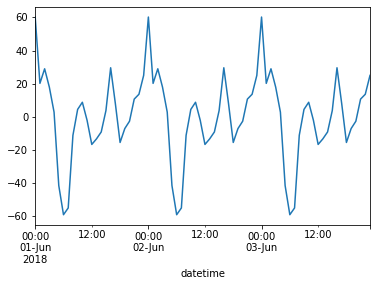

In [16]:
decomposed.seasonal['2018-06-01':'2018-06-03'].plot(ax=plt.gca())

В июне видим те же закономерности. Теперь посмотрим на сезонность в течение часа. 

Посмотрим на скользящее среднее, для этого подберём размер окна

In [17]:
#напишем цикл, в котором переберём разные размеры окон и посмотрим на значение rmse 
for i in range(2,48):
    df['rolling_mean'] = df['num_orders'].rolling(i).mean()
    rmse = mean_squared_error(df['rolling_mean'][i:], df['num_orders'][i:], squared=False)
    print('rmse для скользящего среднего', i, 'равно', rmse)

rmse для скользящего среднего 2 равно 19.509512858604733
rmse для скользящего среднего 3 равно 25.493912459159002
rmse для скользящего среднего 4 равно 29.678366861102006
rmse для скользящего среднего 5 равно 32.405289094199134
rmse для скользящего среднего 6 равно 34.076736079016456
rmse для скользящего среднего 7 равно 35.06957635513487
rmse для скользящего среднего 8 равно 35.41683033372916
rmse для скользящего среднего 9 равно 35.583770879698925
rmse для скользящего среднего 10 равно 35.92682133376726
rmse для скользящего среднего 11 равно 36.230173225073564
rmse для скользящего среднего 12 равно 36.23801013430922
rmse для скользящего среднего 13 равно 36.19917052504399
rmse для скользящего среднего 14 равно 36.24453716981881
rmse для скользящего среднего 15 равно 36.47433442679391
rmse для скользящего среднего 16 равно 36.73695385315841
rmse для скользящего среднего 17 равно 36.84709324579899
rmse для скользящего среднего 18 равно 36.99228210248857
rmse для скользящего среднего 19

Логично, что для маленьких окон значения rmse меньше. Но слишком маленькое окно не обеспечит сглаживания. Поэтому исходя из расчётов выберем размер окна 27. 

<AxesSubplot:xlabel='datetime'>

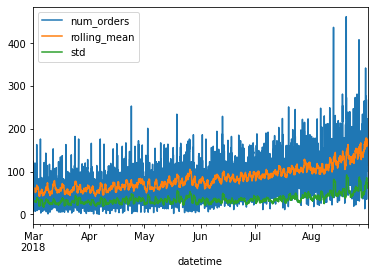

In [18]:
df['rolling_mean'] = df['num_orders'].rolling(27).mean()
df['std'] = df['num_orders'].rolling(27).std()
df.plot()

По скользящему среднему виден тренд на рост. Временной ряд нестационарный - среднее и дисперсия меняются со временем. Сделаем его стационарным, чтобы можно было предсказывать. 

<AxesSubplot:xlabel='datetime'>

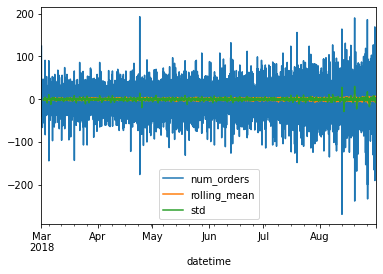

In [19]:
df_shift = df - df.shift(fill_value=0)
df_shift.plot()

## Обучение

Перед обучением создадим признаки. Для этого напишем специальную функцию. 

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    #df_shift['month'] = df_shift.index.month
    #df_shift['day'] = df_shift.index.day
    df_shift['dayofweek'] = df_shift.index.dayofweek
    df_shift['hour'] = df_shift.index.hour
    
    for lag in range(1, max_lag + 1):
        df_shift['lag_{}'.format(lag)] = df_shift['num_orders'].shift(lag)
 
    df_shift['rolling_mean'] = df_shift['num_orders'].shift().rolling(rolling_mean_size).mean()
 


Создаём признаки

In [21]:
make_features(df, 6, 27)

In [22]:
#Посмотрим, что получилось
df_shift

,num_orders,rolling_mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39,NaN,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14,NaN,NaN,3,2,-39.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5,NaN,NaN,3,3,-14.0,-39.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,-23,NaN,NaN,3,4,-5.0,-14.0,-39.0,124.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71,1.888889,-1.390723,4,19,-10.0,20.0,81.0,-17.0,-33.0,30.0
2018-08-31 20:00:00,18,-4.370370,-8.741120,4,20,-71.0,-10.0,20.0,81.0,-17.0,-33.0
2018-08-31 21:00:00,5,-6.962963,-0.049774,4,21,18.0,-71.0,-10.0,20.0,81.0,-17.0


In [23]:
#устраняем пустые значения
df_shift = df_shift.dropna()

Разделим данные на обучающую и тестовую выборки (тестовая выборка - 10% от всех данных). Определим признаки и целевой признак.

In [24]:
train, test = train_test_split(df_shift, shuffle=False, test_size=0.1)

In [25]:
features_train = train.drop(columns='num_orders')
target_train = train['num_orders']
 
features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

Обучим модели. Результат обучения будем смотреть на тренировочной выборке. Затем проверим лучшую модель на тестовой выборке. Сначала обучим модель решающего дерева. 

In [26]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=7)
model_tree.fit(features_train, target_train) 
predicted = model_tree.predict(features_train)
rmse_tree = (mean_squared_error(target_train, predicted))**0.5
print("RMSE для решающего дерева:", rmse_tree)

RMSE для решающего дерева: 24.51153317150433


Попробуем подобрать более оптимальную глубину

In [27]:
#мы пробовали разные диапазоны для поиска оптимальной глубины дерева (от 1 до 10, от 10 до 20 и т.д.), прежде чем остановиться на выбранном
best_model = None
best_result = 0
for depth in range(1, 40):
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predicted = model_tree.predict(features_train)
    result = (mean_squared_error(target_train, predicted))**0.5
    print('max_depth =', depth, ':', result)

max_depth = 27 : 0.019487094073848927
max_depth = 28 : 0.0
max_depth = 29 : 0.0
max_depth = 30 : 0.0
max_depth = 31 : 0.0
max_depth = 32 : 0.0
max_depth = 33 : 0.0
max_depth = 34 : 0.0
max_depth = 35 : 0.0
max_depth = 36 : 0.0
max_depth = 37 : 0.0
max_depth = 38 : 0.0
max_depth = 39 : 0.0


In [28]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=28)
model_tree.fit(features_train, target_train) 
predicted = model_tree.predict(features_train)
rmse_tree = (mean_squared_error(target_train, predicted))**0.5
print("RMSE для решающего дерева:", rmse_tree)

RMSE для решающего дерева: 0.0


In [29]:
target_train

datetime
2018-03-02 03:00:00   -11
2018-03-02 04:00:00   -44
2018-03-02 05:00:00    -9
2018-03-02 06:00:00     0
2018-03-02 07:00:00    -4
                       ..
2018-08-13 12:00:00   -52
2018-08-13 13:00:00    27
2018-08-13 14:00:00   -17
2018-08-13 15:00:00    73
2018-08-13 16:00:00   -31
Freq: H, Name: num_orders, Length: 3950, dtype: int64

In [30]:
predicted

array([-11., -44.,  -9., ..., -17.,  73., -31.])

Лучший результат показывает решающее дерево с глубиной 28. Зафиксируем результат этой модели

In [229]:
model_forest = RandomForestRegressor(max_depth=10, n_estimators=30, min_samples_leaf= 7, random_state=12345)
model_forest.fit(features_train, target_train) 
predicted = model_forest.predict(features_train)
rmse_forest = (mean_squared_error(target_train, predicted))**0.5
print("RMSE для случайного леса:", rmse_forest)

RMSE для случайного леса: 18.858523489162316


Модель случайного леса показывает хороший результат, но попробуем подобрать более оптимальные гиперпараметры.

In [230]:
for depth in range(1, 30):
    model_forest = RandomForestRegressor(random_state=12345, 
                                        n_estimators=30,
                                        min_samples_leaf= 7,
                                        max_depth=depth)
    model_forest.fit(features_train, target_train)
    predicted = model_forest.predict(features_train)
    result = (mean_squared_error(target_train, predicted))**0.5
    print('max_depth =', depth, ':', result)
    

max_depth = 1 : 33.67720062583534
max_depth = 2 : 31.82219549388344
max_depth = 3 : 30.00455721102139
max_depth = 4 : 27.91537248900841
max_depth = 5 : 25.66553858053682
max_depth = 6 : 23.9686363881267
max_depth = 7 : 22.528330519419274
max_depth = 8 : 21.09193254064124
max_depth = 9 : 19.859740557487044
max_depth = 10 : 18.858523489162316
max_depth = 11 : 18.09753610048196
max_depth = 12 : 17.473951122300303
max_depth = 13 : 17.073424653355726
max_depth = 14 : 16.813353858295432
max_depth = 15 : 16.645565215696895
max_depth = 16 : 16.550772067432945
max_depth = 17 : 16.500361118391485
max_depth = 18 : 16.479319253445443
max_depth = 19 : 16.470328845443742
max_depth = 20 : 16.466097247207063
max_depth = 21 : 16.46298060130462
max_depth = 22 : 16.462021580617748
max_depth = 23 : 16.462021580617748
max_depth = 24 : 16.462021580617748
max_depth = 25 : 16.462021580617748
max_depth = 26 : 16.462021580617748
max_depth = 27 : 16.462021580617748
max_depth = 28 : 16.462021580617748
max_depth =

Выбираем глубину 20 и продолжаем подбор

In [156]:
for samples_leaf in range(1, 10):
    model_forest = RandomForestRegressor(random_state=12345, 
                                        n_estimators=30,
                                        min_samples_leaf= samples_leaf,
                                        max_depth=22)
    model_forest.fit(features_train, target_train)
    predicted = model_forest.predict(features_train)
    result = (mean_squared_error(target_train, predicted))**0.5
    print('min_samples_leaf =', samples_leaf, ':', result)

min_samples_leaf = 1 : 8.929825838425307
min_samples_leaf = 2 : 10.37353180049809
min_samples_leaf = 3 : 12.055549651045373
min_samples_leaf = 4 : 13.621335600620332
min_samples_leaf = 5 : 14.81006240270706
min_samples_leaf = 6 : 15.736158544432778
min_samples_leaf = 7 : 16.462021580617748
min_samples_leaf = 8 : 17.066491044844682
min_samples_leaf = 9 : 17.664024935820915


Фиксируем гиперпараметры для модели случайного леса - max_depth=22, n_estimators=30, min_samples_leaf= 2. (Количество деревьев мы также пробовали подбирать, однако оно, как выяснилось, почти не влияет на результат)

In [231]:
model_forest = RandomForestRegressor(max_depth=20, n_estimators=30, min_samples_leaf= 2, random_state=12345)
model_forest.fit(features_train, target_train) 
predicted = model_forest.predict(features_train)
rmse_forest = (mean_squared_error(target_train, predicted))**0.5
print("RMSE для случайного леса:", rmse_forest)

RMSE для случайного леса: 10.477848419979267


Обучим модель линеарной регрессии

In [232]:
model_lg = LinearRegression()
model_lg.fit(features_train, target_train)
predicted = model_lg.predict(features_train)
rmse_lg = (mean_squared_error(target_train, predicted))**0.5
print("RMSE для линеарной регрессии:", rmse_lg)

RMSE для линеарной регрессии: 31.602314705921838


In [233]:
model_lgb = LGBMRegressor()
model_lgb.fit(features_train, target_train)
predicted = model_lgb.predict(features_train)
rmse_lgb = (mean_squared_error(target_train, predicted))**0.5
print("RMSE для градиентного бустинга:", rmse_lgb)

RMSE для градиентного бустинга: 13.431156122854988


In [235]:
data_dict = {'model': ['Случайный лес', 'Линеарная регрессия', 'Градиентный бустинг'],
            'RMSE': [rmse_forest,rmse_lg,rmse_lgb]}
pd.DataFrame(data_dict)

,model,RMSE
0,Случайный лес,10.477848
1,Линеарная регрессия,31.602315
2,Градиентный бустинг,13.431156


Лучший результат по rmse показала модель случайного леса. Теперь проверим её на тестовой выборке.

## Тестирование модели

Проверим на тестовой выборке модель случайного леса, которая показала лучший результат при обучении.

In [158]:
predicted = model_forest.predict(features_test)
print("RMSE для случайного леса:", (mean_squared_error(target_test, predicted))**0.5)

RMSE для случайного леса: 42.87735399796275


Значение rmse нас удовлетворяет. Построим график, который продемонстрирует, как модель предсказывает результат. 

<AxesSubplot:xlabel='datetime'>

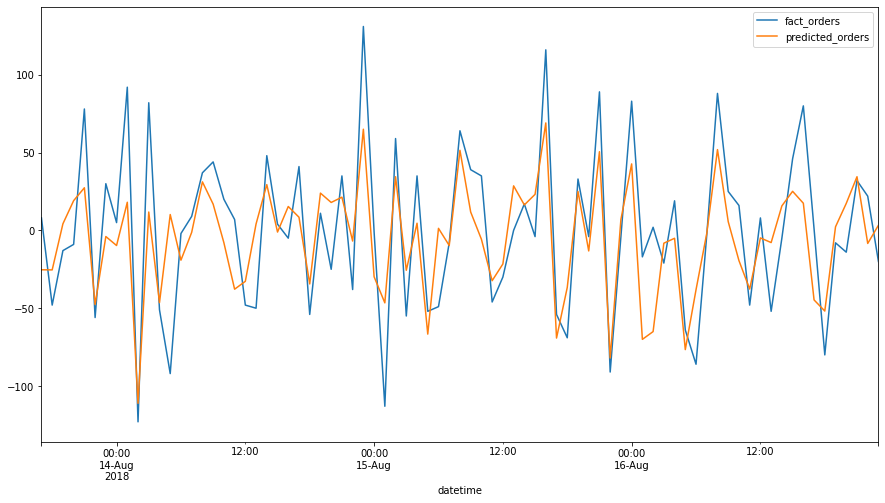

In [200]:
target_test_tmp = target_test.reset_index()
target_test_tmp = target_test_tmp.join(predicted_df, how = 'left' )
target_test_tmp = target_test_tmp.rename(columns = {'num_orders': 'fact_orders', 0: 'predicted_orders'})
target_test_tmp = target_test_tmp.set_index('datetime')
target_test_tmp['2018-08-13':'2018-08-16'].plot(figsize=(15,8))


## Выводы

Мы работали с историческими данными о заказах такси в аэропортах. Нашей задачей было обучить модель для прогнозирования количества заказов такси на следующий час.
Сначала мы ознакомились с данными, привели их к нужному формаут и произвели ресемплирование по одному часу (так как в задаче прогноза фигурирует следующий час). 
Затем мы проанализировали данные, зафиксировали тренд на рост числа заказов с каждым месяцем. Мы также обнаружили, что данный временной ряд не является стационарным, а так как нам необходимо было осуществить прогноз, то мы привели временной ряд к стационарному состоянию.
Далее мы разбили данные на обучающую и тестовую выборки и обучили несколько моделей. Лучший результат по rmse показала модель градиентного бустинга, которую мы и предлагаем использовать для прогноза.